# The Process


Below is a typical workflow for a Data Science project such as mine.


Define Objective

Data Sources

Explore Data

Analysis Dataset
•	Feature Engineering
•	Training Data
•	Test Data

Machine Learning
•	Train Model
•	Predict Test data
•	Evaluate Model



# The Data


I am going to use a dataset containing more than forty-thousand clients of a bank. The dataset is available as CSV files.


# Setup


First, I am going to load a few R libraries from CRAN - the Comprehensive R Archive Network - into the environment.

In [1]:
# prepare the R environment
if (!require("pacman")) install.packages("pacman")
pacman::p_load(
  dplyr,         # Data munging functions
  zoo,              # Feature engineering rolling aggregates
  data.table,       # Feature engineering
  ggplot2,          # Graphics
  scales,           # Time formatted axis
  readr,            # Reading input files
  stringr,          # String functions
  reshape2,         # restructure and aggregate data 
  randomForest,     # Random forests
  corrplot,         # correlation plots
  Metrics,          # Eval metrics for ML
  vcd               # Visualizing discrete distributions
)

Loading required package: pacman
Warning message:
"package 'pacman' was built under R version 3.4.4"

In [2]:
# set options for plots
options(repr.plot.width=6, repr.plot.height=6)

In [3]:
# Load the data
bm <-"C:\\Users\\Mirela\\RStudioProjects\\Marketing\\datasets\\bank-marketing.csv"

if(!file.exists(bm)){tryCatch(bm)}

if(file.exists(bm)) bm_original <- read.csv(bm, header = TRUE, stringsAsFactors = FALSE, sep = ";")

head(bm_original)


age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no




First let's perform some basic cleanup on the dataset.



In [4]:
# eliminate any duplicates that may exist in the dataset

bank <- bm_original%>%
  distinct(.keep_all = TRUE,age, job, marital, education,balance)


In [5]:
# generate an id column for future use (joins etc)
bank$bank_id = seq.int(nrow(bank))

head(bank)
summary(bank)

age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,bank_id
58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,1
44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,2
33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,3
47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no,4
33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no,5
35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no,6


      age            job              marital           education        
 Min.   :18.00   Length:39953       Length:39953       Length:39953      
 1st Qu.:33.00   Class :character   Class :character   Class :character  
 Median :39.00   Mode  :character   Mode  :character   Mode  :character  
 Mean   :40.94                                                           
 3rd Qu.:48.00                                                           
 Max.   :95.00                                                           
   default             balance         housing              loan          
 Length:39953       Min.   : -8019   Length:39953       Length:39953      
 Class :character   1st Qu.:   106   Class :character   Class :character  
 Mode  :character   Median :   492   Mode  :character   Mode  :character  
                    Mean   :  1411                                        
                    3rd Qu.:  1500                                        
                    Max.   :1021

# Data Exploration and Visualisation


R has some useful tools to turn it into a picture a dataset, the best way to understand - and a lot of them come with the very popular ggplot2 package.



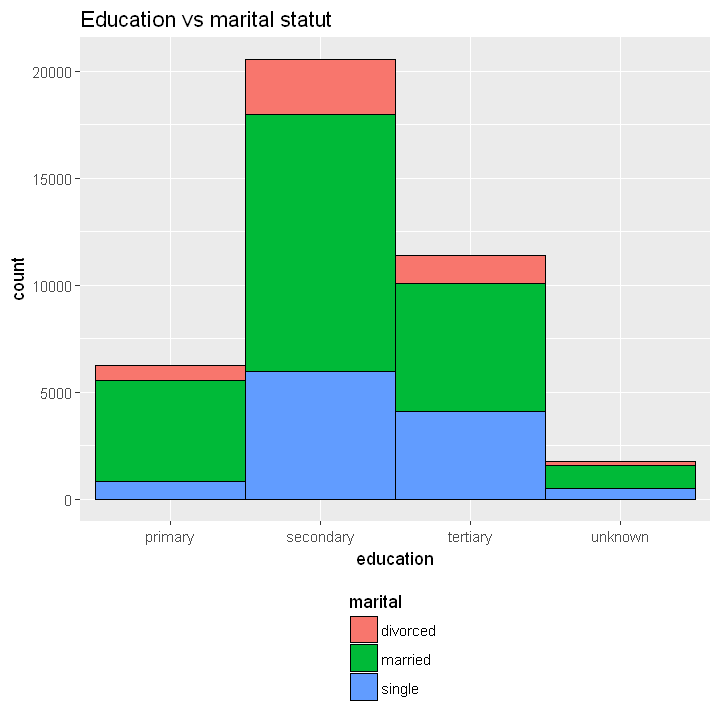

In [6]:
# how many clients has got the bank regarding education & marital statut?
bank %>%
  ggplot(mapping = aes(education)) +
  geom_bar(aes(fill=marital), width=1, color="black") +
  theme(legend.position = "bottom", legend.direction = "vertical") + ggtitle("Education vs marital statut")


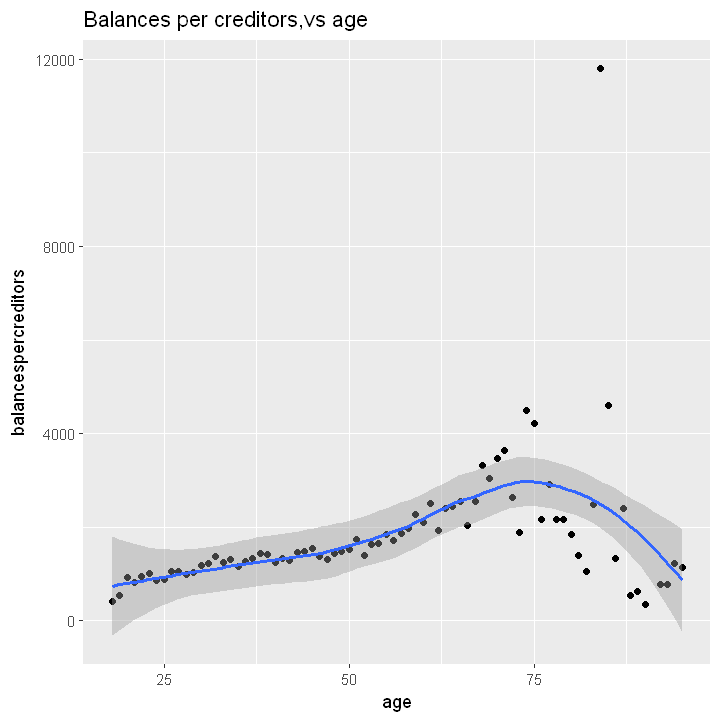

In [7]:
# how evolving the balance by clients age ? 
bank %>%
  dplyr::group_by(age = age) %>%
  dplyr::summarize(
    totalcreditors = n(),
    totalbalances = sum(balance),
    balancespercreditors = totalbalances / totalcreditors
  ) %>%
  ggplot(mapping = aes(x = age, y = balancespercreditors)) +
  geom_point() +
  geom_smooth(method = "loess") + ggtitle("Balances per creditors,vs age")

In [8]:
summary(bank$balance)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  -8019     106     492    1411    1500  102127 



Now, we can create some aditional features about the education of the clients.




In [9]:
# creditors education type: Tertiary, Primary, Secondary,Unknown

bank$tertiary <- FALSE
bank$tertiary[bank$education == "Tertiary"] <- TRUE

bank$primary <- FALSE
bank$primary[bank$education %like% "Primary"] <- TRUE

bank$secondary <- FALSE
bank$secondary[bank$education %like% "Secondary"] <- TRUE

bank$unknown <- FALSE
bank$unknown[bank$education %like% "Unknown"] <- TRUE

head(bank)


age,job,marital,education,default,balance,housing,loan,contact,day,...,campaign,pdays,previous,poutcome,y,bank_id,tertiary,primary,secondary,unknown
58,management,married,tertiary,no,2143,yes,no,unknown,5,...,1,-1,0,unknown,no,1,FALSE,FALSE,FALSE,FALSE
44,technician,single,secondary,no,29,yes,no,unknown,5,...,1,-1,0,unknown,no,2,FALSE,FALSE,FALSE,FALSE
33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,...,1,-1,0,unknown,no,3,FALSE,FALSE,FALSE,FALSE
47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,...,1,-1,0,unknown,no,4,FALSE,FALSE,FALSE,FALSE
33,unknown,single,unknown,no,1,no,no,unknown,5,...,1,-1,0,unknown,no,5,FALSE,FALSE,FALSE,FALSE
35,management,married,tertiary,no,231,yes,no,unknown,5,...,1,-1,0,unknown,no,6,FALSE,FALSE,FALSE,FALSE




At this point, we're going to eliminate the clients with unknown education from the dataset.



In [10]:
# not use unknown education creditors 

bank <- bank %>% dplyr::filter(unknown == FALSE)


In [11]:
# transform the bank - marketing  table into a bank performance table
bkmk_perf <- bank %>%
dplyr::mutate(
bal = (balance > 1000),
dtion = (duration < 150),
edumar = (education == "tertiary" & marital == "married")
) %>%
dplyr::select (bank_id,age,job,marital,edumar,bal,housing,dtion)
head(bkmk_perf)

bank_id,age,job,marital,edumar,bal,housing,dtion
1,58,management,married,TRUE,TRUE,yes,FALSE
2,44,technician,single,FALSE,FALSE,yes,FALSE
3,33,entrepreneur,married,FALSE,FALSE,yes,TRUE
4,47,blue-collar,married,FALSE,TRUE,yes,TRUE
5,33,unknown,single,FALSE,FALSE,no,FALSE
6,35,management,married,TRUE,FALSE,yes,TRUE


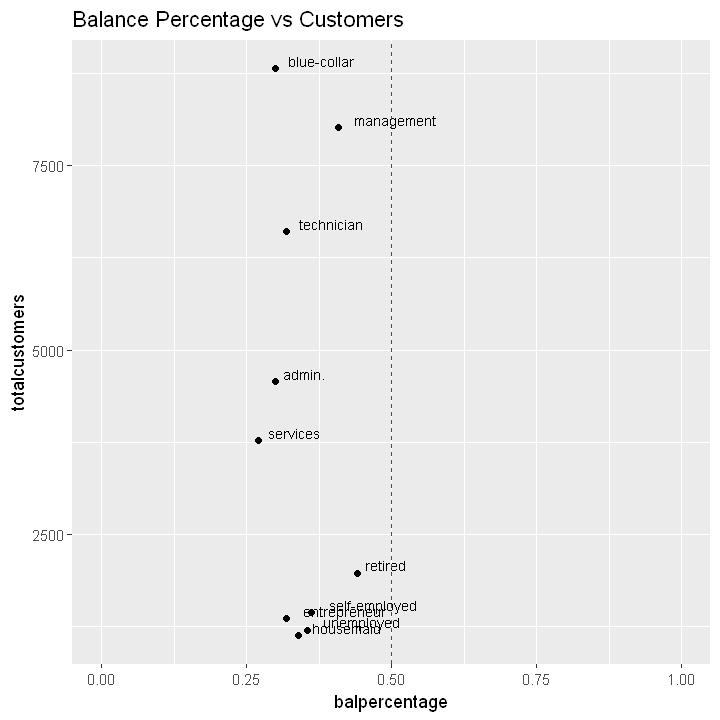

In [12]:
formula_balpercentage <- function(totalcustomers, balance) {
  return ((balance) / totalcustomers)
}

plot_balpercentage <- function(bkmk_perf, mincustomers) {
  bkmk_perf %>%
    group_by(job) %>%
    summarize(
      totalcustomers = n(),
      balance = length(bal[bal==TRUE]),
      balpercentage = formula_balpercentage(totalcustomers, balance)
    ) %>%
    filter(totalcustomers >= mincustomers ) %>%
    ggplot(mapping = aes(x = balpercentage, y = totalcustomers)) +
    geom_point(size = 1.5) + 
    geom_text(aes(label=job), hjust=-.2 , vjust=-.2, size=3) +
    geom_vline(xintercept = .5, linetype = 2, color = "red") +
    ggtitle("Balance Percentage vs Customers") +
    expand_limits(x = c(0,1))
} 

plot_balpercentage(bkmk_perf, 900)

In [13]:
# transform old job names into new ones( with CL).
jobNodeMappings <- matrix(c(
  "management","Management",
  "technician","Technician",
  "entrepreneur","Entrepreneur",
  "blue-collar","Blue-collar",
  "unknown","Unknown",
  "services","Services",
  "retired","Retired"
), ncol=2, byrow = TRUE)


In [14]:
for (i in 1:nrow(jobNodeMappings)) {
  bkmk_perf$job[bkmk_perf$job == jobNodeMappings[i,1]] <- jobNodeMappings[i,2]
  
  bank$job[bank$job == jobNodeMappings[i,1]] <- jobNodeMappings[i,2]
  
}

head(bkmk_perf)

bank_id,age,job,marital,edumar,bal,housing,dtion
1,58,Management,married,TRUE,TRUE,yes,FALSE
2,44,Technician,single,FALSE,FALSE,yes,FALSE
3,33,Entrepreneur,married,FALSE,FALSE,yes,TRUE
4,47,Blue-collar,married,FALSE,TRUE,yes,TRUE
5,33,Unknown,single,FALSE,FALSE,no,FALSE
6,35,Management,married,TRUE,FALSE,yes,TRUE




Since our model will predict bank marketing results, it would be useful to also look at the distribution of marital statut as well as balance per client.



In [15]:
# what is the occurence frequency for martital statut?

maritalfreq <- bank %>%
  group_by(marital,job) %>%
  summarise(
    n = n(),
    freq = n / nrow(bank)
  ) %>%
  ungroup() %>%
  mutate(
    maritaltext = paste(marital,"vs",job)
  ) %>%
  arrange(desc(freq)) 

head(maritalfreq, 15)

marital,job,n,freq,maritaltext
married,Blue-collar,6262,0.15673416,married vs Blue-collar
married,Management,4548,0.11383375,married vs Management
married,Technician,3468,0.08680199,married vs Technician
single,Management,2508,0.06277376,single vs Management
married,admin.,2338,0.05851876,married vs admin.
single,Technician,2313,0.05789302,single vs Technician
married,Services,2156,0.05396341,married vs Services
single,Blue-collar,1852,0.04635447,single vs Blue-collar
single,admin.,1540,0.03854529,single vs admin.
married,Retired,1477,0.03696844,married vs Retired


In [16]:
# distribution of balance per customer
balancefreq <- bank %>%
  group_by(bal= balance) %>%
  summarise(
    n = n(),
    freq = n / nrow(bank)
  ) %>%
  ungroup() %>%
  arrange(desc(freq)) 

head(balancefreq, 25)

bal,n,freq
0,1283,0.032112732
1,171,0.004280029
2,132,0.003303882
3,119,0.002978500
4,115,0.002878382
5,102,0.002553000
6,84,0.002102470
8,74,0.001852176
23,70,0.001752059
10,64,0.001601882


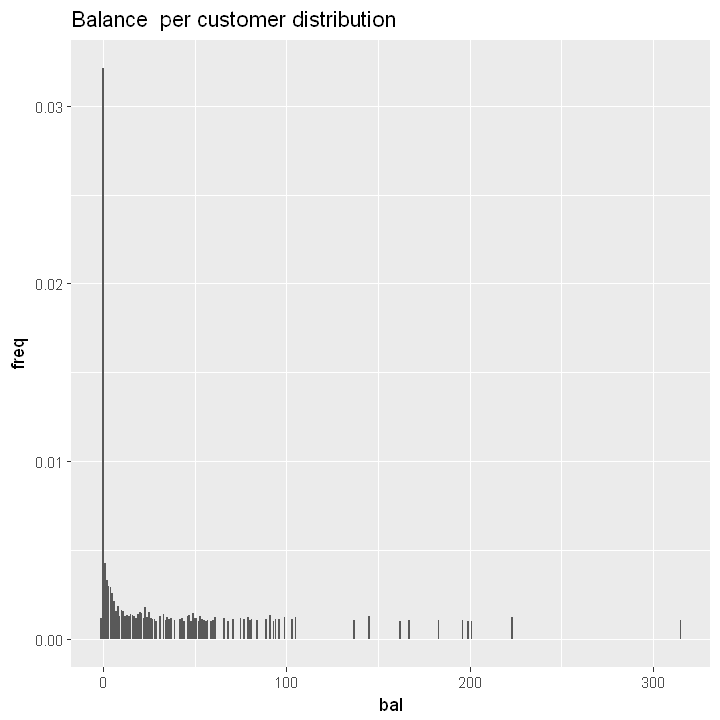

In [17]:
balancefreq %>%
  filter(freq >= 0.001) %>%
  ggplot(mapping = aes(x = bal, y = freq)) + geom_bar(stat = "identity") + ggtitle("Balance  per customer distribution")

In [18]:
# distribution of customer age
agefreq <- bank %>%
  group_by(ctage = age) %>%
  summarise(
    n = n(),
    freq = n / nrow(bank)
  ) %>%
  ungroup() %>%
  arrange(ctage) 

head(agefreq %>% filter(abs(ctage)<=35), 15)

ctage,n,freq
18,9,0.0002252647
19,29,0.0007258529
20,42,0.0010512352
21,72,0.0018021175
22,116,0.0029034115
23,186,0.0046554702
24,276,0.0069081170
25,477,0.0119390284
26,732,0.0183215278
27,832,0.0208244688


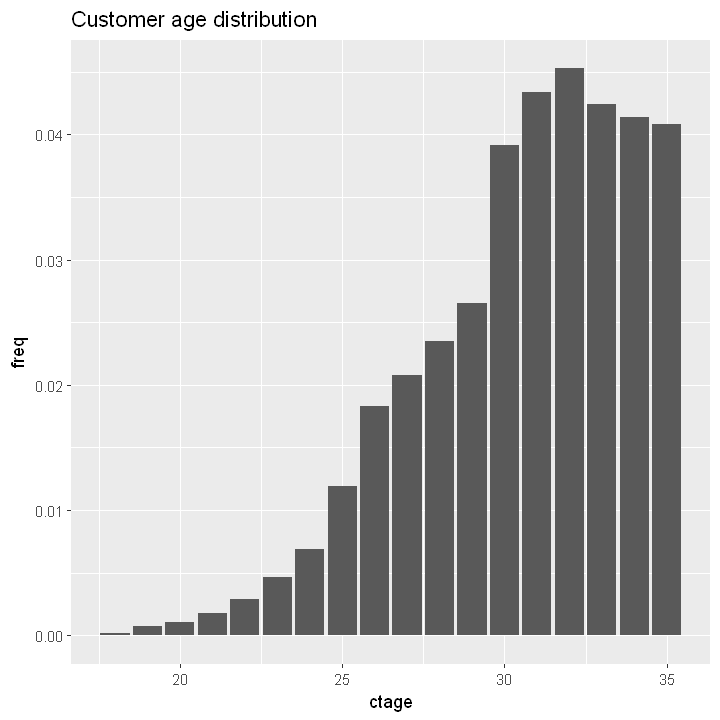

In [19]:
agefreq %>%
  filter(abs(ctage)<=35) %>%
  ggplot(mapping = aes(x = ctage, y = freq)) + geom_bar(stat = "identity") + ggtitle("Customer age distribution")

# Outliers

I'd like to get rid of outliers - values which are far away at the end of the spectrum of possible values for this variable. The reason is that outliers can drastically change the results of the data analysis and statistical modeling. Outliers increase the error variance, reduce the power of statistical tests, and ultimately they can bias or influence estimates.



In [20]:
# how many outliers do we have?
out <- bank %>% dplyr::filter(abs(balance) > 8000)
head(out)
paste(nrow(out), "outliers, or", (nrow(out)/nrow(bank)*100), "% of total.")


age,job,marital,education,default,balance,housing,loan,contact,day,...,campaign,pdays,previous,poutcome,y,bank_id,tertiary,primary,secondary,unknown
51,Management,married,tertiary,no,10635,yes,no,unknown,5,...,1,-1,0,unknown,no,35,FALSE,FALSE,FALSE,FALSE
35,Blue-collar,single,secondary,no,12223,yes,yes,unknown,5,...,1,-1,0,unknown,no,70,FALSE,FALSE,FALSE,FALSE
45,Management,divorced,tertiary,no,24598,yes,no,unknown,5,...,3,-1,0,unknown,no,335,FALSE,FALSE,FALSE,FALSE
40,Management,married,secondary,no,8486,no,no,unknown,6,...,3,-1,0,unknown,no,383,FALSE,FALSE,FALSE,FALSE
37,Technician,married,tertiary,no,8730,yes,no,unknown,6,...,1,-1,0,unknown,no,392,FALSE,FALSE,FALSE,FALSE
39,Technician,single,unknown,no,45248,yes,no,unknown,6,...,1,-1,0,unknown,yes,446,FALSE,FALSE,FALSE,FALSE


[1] "1165 outliers, or 2.91592621330063 % of total."

In [21]:
# get rid of all the outliers by selecting the balance to [-8000, 8000]
bkmk_perf$bal[bkmk_perf$bal < -8000] <- -8000
bkmk_perf$bal[bkmk_perf$bal > 8000] <- 8000


In [22]:
# job and adjustment coefficients for them

jobs <- as.data.frame(matrix(c(
  "management","0.99",
  "technician","0.75",
  "entrepreneur","0.9",
  "blue-collar","0.8",
  "unknown","0.5",
  "services","0.85",
  "retired","0.8"  
), ncol=2, byrow = TRUE, dimnames = list(NULL, c("job","adjust"))), stringsAsFactors = FALSE)

jobs$job <- as.vector(jobs$job)
jobs$adjust <- as.numeric(jobs$adjust)

In [23]:
bkmk_perf <- bkmk_perf %>%
  dplyr::left_join(jobs, by=c("job")) %>%
  dplyr::select(bank_id,age,job,adjust,marital,edumar,bal,housing,dtion)


In [24]:
# set missing values to 1

bkmk_perf$adjust[is.na(bkmk_perf$adjust)] <- 1

# Feature Engineering

Now, let's calculate some lag features for the clients of the bank.

We'll look at the previous N clients, and we'll calculate the percentage of bal, dtion, edumar for those past N clients.

For example, taking N=10:

    last10customers_bal_per = lagfn_per(bal, 10),
    last10customers_dtion_per = lagfn_per(dtion, 10),
    last10customers_edumar_per = lagfn_per(edumar, 10),         

We'll use three different values for N (10, 30 and 50) to capture short-, medium-, and long-term form.



In [25]:
# Let's calculate some lag features           
# we'll take three windows: last 10 customers, last 30 customers, last 50 customers.
# for each window we'll calculate some values

lagfn <- function(data, width) {
  return (rollapplyr(data, width = width + 1, FUN = sum, fill = NA, partial=TRUE) - data)
}

lagfn_per <- function(data, width) {
  return (lagfn(data, width) / width)
}

bankperf_features <- bkmk_perf %>%
  dplyr::arrange(job, age) %>%
  dplyr::group_by(job) %>%
  dplyr::mutate(
    last10customers_bal_per = lagfn_per(bal, 10),
    last30customers_bal_per = lagfn_per(bal, 30),
    last50customers_bal_per = lagfn_per(bal, 50),
    
    last10customers_dtion_per = lagfn_per(dtion, 10),
    last30customers_dtion_per = lagfn_per(dtion, 30),
    last50customers_dtion_per = lagfn_per(dtion, 50),
    
    last10customers_edumar_per = lagfn_per(edumar, 10),
    last30customers_edumar_per = lagfn_per(edumar, 30),
    last50customers_edumar_per = lagfn_per(edumar, 50),
    
    
  ) %>%
  dplyr::select (
    bank_id, age, job,adjust,
    bal, last10customers_bal_per, last30customers_bal_per, last50customers_bal_per,
    dtion, last10customers_dtion_per, last30customers_dtion_per, last50customers_dtion_per,
    edumar,last10customers_edumar_per, last30customers_edumar_per, last50customers_edumar_per
    
  ) %>%
  dplyr::ungroup()

head((bankperf_features %>% dplyr::filter(job == "technician" & age >= '20')), n = 100)
summary(bankperf_features)

bank_id,age,job,adjust,bal,last10customers_bal_per,last30customers_bal_per,last50customers_bal_per,dtion,last10customers_dtion_per,last30customers_dtion_per,last50customers_dtion_per,edumar,last10customers_edumar_per,last30customers_edumar_per,last50customers_edumar_per


    bank_id           age            job                adjust 
 Min.   :    1   Min.   :18.00   Length:39953       Min.   :1  
 1st Qu.: 9989   1st Qu.:33.00   Class :character   1st Qu.:1  
 Median :19977   Median :39.00   Mode  :character   Median :1  
 Mean   :19977   Mean   :40.94                      Mean   :1  
 3rd Qu.:29965   3rd Qu.:48.00                      3rd Qu.:1  
 Max.   :39953   Max.   :95.00                      Max.   :1  
      bal         last10customers_bal_per last30customers_bal_per
 Min.   :0.0000   Min.   :0.0000          Min.   :0.0000         
 1st Qu.:0.0000   1st Qu.:0.2000          1st Qu.:0.2333         
 Median :0.0000   Median :0.3000          Median :0.3333         
 Mean   :0.3361   Mean   :0.3351          Mean   :0.3336         
 3rd Qu.:1.0000   3rd Qu.:0.5000          3rd Qu.:0.4000         
 Max.   :1.0000   Max.   :1.0000          Max.   :0.8000         
 last50customers_bal_per   dtion         last10customers_dtion_per
 Min.   :0.0000        


Now that we have built a series of bank_perf features, we need to fold them back into -bank features.



In [26]:
# fold per-bank_perf features into per-bank features
bank_features <- bank %>%
  left_join(bankperf_features, by=c("bank_id", "age" = "age")) %>%
  dplyr::select(
    age,marital,education,housing,duration,
    last10customers_bal_per,
    last30customers_bal_per,
    last50customers_bal_per,
    last10customers_dtion_per,
    last30customers_dtion_per,
    last50customers_dtion_per,
    last10customers_edumar_per,
    last30customers_edumar_per, 
    last50customers_edumar_per,
    outcome=balance
  )

head(bank_features)
names(bank_features)

age,marital,education,housing,duration,last10customers_bal_per,last30customers_bal_per,last50customers_bal_per,last10customers_dtion_per,last30customers_dtion_per,last50customers_dtion_per,last10customers_edumar_per,last30customers_edumar_per,last50customers_edumar_per,outcome
58,married,tertiary,yes,261,0.5,0.4333333,0.42,0.2,0.3333333,0.36,0.5,0.50000000,0.54,2143
44,single,secondary,yes,151,0.4,0.3333333,0.38,0.2,0.3000000,0.44,0.0,0.03333333,0.10,29
33,married,secondary,yes,76,0.3,0.3000000,0.26,0.4,0.4333333,0.46,0.3,0.33333333,0.26,2
47,married,unknown,yes,92,0.6,0.5333333,0.44,0.5,0.4666667,0.38,0.1,0.03333333,0.02,1506
33,single,unknown,no,198,0.3,0.3333333,0.20,0.7,0.4000000,0.24,0.1,0.03333333,0.02,1
35,married,tertiary,yes,139,0.2,0.4000000,0.44,0.3,0.3000000,0.26,0.4,0.60000000,0.62,231


[1] "age"                        "marital"                   
 [3] "education"                  "housing"                   
 [5] "duration"                   "last10customers_bal_per"   
 [7] "last30customers_bal_per"    "last50customers_bal_per"   
 [9] "last10customers_dtion_per"  "last30customers_dtion_per" 
[11] "last50customers_dtion_per"  "last10customers_edumar_per"
[13] "last30customers_edumar_per" "last50customers_edumar_per"
[15] "outcome"

Let's also have a look at how correlated our numeric features are:

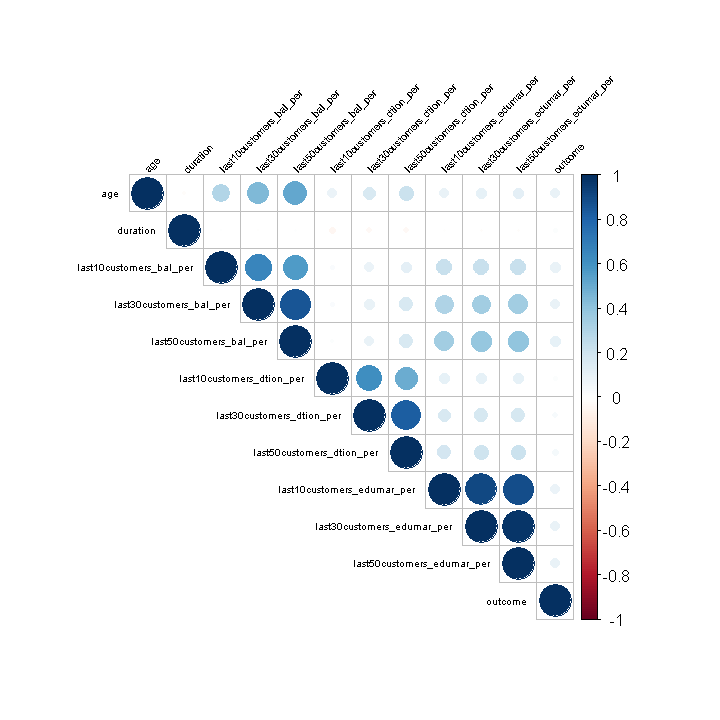

In [27]:
# correlation matrix
cormatrix <- cor(bank_features %>% dplyr::select(-c(marital,education, housing)) )
corrplot(cormatrix, type = "upper", order = "original", tl.col = "black", tl.srt = 45, tl.cex = 0.5)



The next step is to create a training formula for our model - it is going to describe the features we want to use and the outcome we're trying to predict


In [28]:
# create the training formula 
trainformula <- as.formula(paste('outcome',
                                 paste(names(bank_features %>% dplyr::select(-c(age,marital,education, housing,outcome))),collapse=' + '),
                                 sep=' ~ '))
trainformula



outcome ~ duration + last10customers_bal_per + last30customers_bal_per + 
    last50customers_bal_per + last10customers_dtion_per + last30customers_dtion_per + 
    last50customers_dtion_per + last10customers_edumar_per + 
    last30customers_edumar_per + last50customers_edumar_per

I m going to split our bank_features into a training and a testing dataset.I m going to be using the training data to fit our model, then I m going to use the testing data to evaluate its accuracy.

In [29]:
# training and testing datasets

data.train1 <- bank_features %>% dplyr::filter(age < '55')
data.test1 <- bank_features %>% dplyr::filter(age>= '55' & age <='71')

nrow(data.train1)
nrow(data.test1)

[1] 34925

[1] 4680

Now it's time to train our model.

The R implementation of the random forest algorithm is available in the randomForest package.

We're going to tell the algorithm to grow 200 trees.

In [30]:
# train a random forest
model.randomForest1 <- randomForest::randomForest(trainformula, data = data.train1, 
                                                  importance = TRUE, ntree = 200)

summary(model.randomForest1)

                Length Class  Mode     
call                5  -none- call     
type                1  -none- character
predicted       34925  -none- numeric  
mse               200  -none- numeric  
rsq               200  -none- numeric  
oob.times       34925  -none- numeric  
importance         20  -none- numeric  
importanceSD       10  -none- numeric  
localImportance     0  -none- NULL     
proximity           0  -none- NULL     
ntree               1  -none- numeric  
mtry                1  -none- numeric  
forest             11  -none- list     
coefs               0  -none- NULL     
y               34925  -none- numeric  
test                0  -none- NULL     
inbag               0  -none- NULL     
terms               3  terms  call     


# Model Evaluation

In order to understand the importance of our predictors to the predicted outcome, we can use some built-in functions from the randomForest package:


,%IncMSE
duration,-1.821959
last10customers_bal_per,15.738557
last30customers_bal_per,15.816171
last50customers_bal_per,11.118700
last10customers_dtion_per,14.468942
last30customers_dtion_per,6.634811
last50customers_dtion_per,9.468055
last10customers_edumar_per,15.768555
last30customers_edumar_per,15.230907
last50customers_edumar_per,17.298080


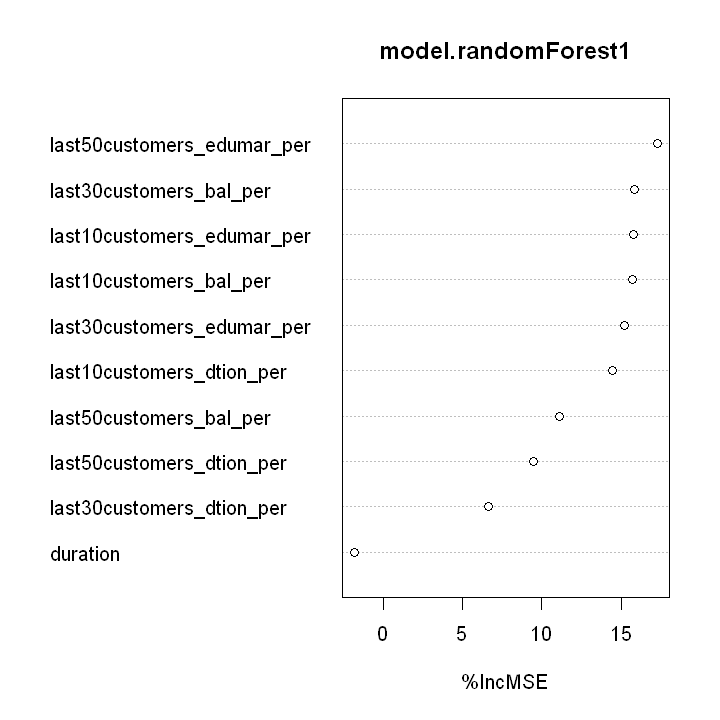

In [31]:

randomForest::importance(model.randomForest1, type=1)
randomForest::varImpPlot(model.randomForest1, type=1)

We can now expose our trained model to the test dataset, and calculate performance metrics.

In [32]:
data.pred.randomForest1 <- predict(model.randomForest1, data.test1, predict.all = TRUE)


In [33]:
metrics.randomForest1.mae <- Metrics::mae(data.test1$outcome, data.pred.randomForest1$aggregate)
metrics.randomForest1.rmse <- Metrics::rmse(data.test1$outcome, data.pred.randomForest1$aggregate)

In [34]:
paste("Mean Absolute Error:", metrics.randomForest1.mae)
paste("Root Mean Square Error:",metrics.randomForest1.rmse)


[1] "Mean Absolute Error: 2109.03476656127"

[1] "Root Mean Square Error: 4552.18913274993"

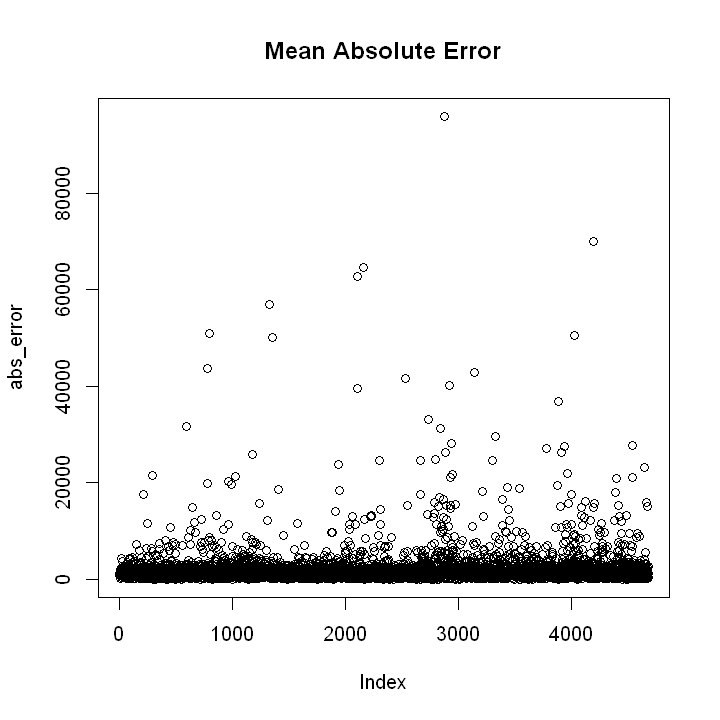

In [35]:
abs_error <- abs(data.test1$outcome - data.pred.randomForest1$aggregate)
plot(abs_error, main="Mean Absolute Error")